# Model Optimization with PyTorch

- See: https://pytorch.org/tutorials/index.html

## Hyperparameter Tuning with Ray Tune

- From: https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html
- Ray Tune Docs: https://docs.ray.io/en/latest/tune/index.html
- Note: Tutorial is based on an original CNN tutorial. The comments marked by "HPT" show the new changes/additions with the hyperparameter tuning tutorial

Ray Tune is an open source library for hyperparameter tuning. It contains the latest search algorithms, integrates with TensorBoard and other analysis libraries, and supports distributed training.

### CIFAR10 Classifier

In [ ]:
# HPT
%pip install ray[tune]
%pip install ray

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np


# HPT
from functools import partial
import os
import tempfile
from pathlib import Path
from torch.utils.data import random_split
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle

In [ ]:
# HPT
# Wrap the data loaders and pass a directory to access data from different trials

def load_data(data_dir="./data"):
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))] # Normalize from [0, 1] to [-1, 1]
    )

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform
    )

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform
    )

    return trainset, testset

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
def imshow(img):
    img = img / 2 + 0.3 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
# HPT
# Make parameters of the model (l1, l2) configurable to allow for tuning

class Net(nn.Module):
    def __init__(self, l1=120, l2=84):
        super().__init__()
        # input is 3 x 32 x 32
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, len(classes))

    def forward(self, x):
        # 3 x 32 x 32
        x = self.pool(F.relu(self.conv1(x)))
        # 6 x 14 x 14
        x = self.pool(F.relu(self.conv2(x)))
        # 16 x 5 x 5
        x = torch.flatten(x, 1) # Flatten dimensions except for batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# HPT
# Wrap the training function with a few
#  - config specifies the hyperparameters to train with (l1, l2, lr, bs)
#  - data_dir gives the dirctory to load and store data
#  - Use the GPU and DataParallel if available
#  - Saving training checkpoints for advanced schedulers and fault tolerance
#  - Sending validation loss and accuracy to Ray Tune for evaluation

def train_cifar(config, data_dir=None):
    net = Net(config["l1"], config["l2"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)


    checkpoint = get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "rb") as fp:
                checkpoint_state = pickle.laod(fp)
            start_epoch = checkpoint_state["epoch"]
            net.load_state_dict(checkpoint_state["net_state_dict"])
            optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0


    trainset, testset = load_data(data_dir)

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs]
    )

    trainloader = torch.utils.data.DataLoader(
        train_subset, batch_size=int(config["batch_size"]), shuffle=True, num_workers=8
    )

    valloader = torch.utils.data.DataLoader(
        val_subset, batch_size=int(config["batch_size"]), shuffle=True, num_workers=8
    )


    for epoch in range(start_epoch, 10):
        running_loss = 0.0
        epoch_steps = 0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:
                print(f"[{epoch+1}, {i + 1:5d}] loss: {running_loss / epoch_steps:.3f}")
                running_loss = 0.0
                epoch_steps = 0


        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, (inputs, labels) in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)

                _, predicted = torch.max(outputs.detach(), 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_steps += 1


        checkpoint_data = {
            "epoch" : epoch,
            "net_state_dict": net.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }
        with tempfile.TemporaryDirectory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "wb") as fp:
                pickle.dump(checkpoint_data, fp)

            checkpoint = Checkpoint.from_directory(checkpoint_dir)
            train.report(
                {"loss": val_loss / val_steps, "accuracy": correct / total},
                checkpoint=checkpoint,
            )

    print("Finished Training")

In [ ]:
# HPT
# Wrap a test accuracy function

def test_accuracy(net, device="cpu"):
    batch_size = 4
    trainset, testset = load_data()
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    correct = 0
    total = 0
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    with torch.no_grad():
        for (images, labels) in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.detach(), 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            for label, prediction in zip(labels, predicted):
                total_pred[classes[label]] += 1
                if label == prediction:
                    correct_pred[classes[label]] += 1

        dataiter = iter(testloader)
        images, labels = next(dataiter)

        imshow(torchvision.utils.make_grid(images))
        print('GroundTruth: ', ' '.join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

        outputs = net(images.to(device))
        _, predicted = torch.max(outputs, 1)
        print('Predicted: ', ' '.join(f"{classes[predicted[j]]:5s}" for j in range(batch_size)))


    return correct / total, correct_pred, total_pred

In [ ]:
# HPT
# Wrap the tune functionality
# - Setup the config parameters
# - Use the ASHAScheduler, which terminates bad performing trials early
# - Specify the available CPU and GPU (can be a fraction)

def tune_model(num_samples=10, max_num_epochs=10, gpus_per_trial=1):
    data_dir = os.path.abspath("./data")
    load_data(data_dir)

    config = {
        "l1": tune.choice([2 ** i for i in range(4, 9)]),
        "l2": tune.choice([2 ** i for i in range(4, 9)]),
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([2 ** i for i in range(1, 5)])
    }

    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2,
    )

    result = tune.run(
        partial(train_cifar, data_dir=data_dir),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
    )

    return result

In [ ]:
# Check devices
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    print(f"cuda device count: {torch.cuda.device_count()}")
print(f"Device: {device}")
gpus_per_trial = 1

cuda device count: 1
Device: cuda:0


In [ ]:
# HPT
# Run the optimization
result = tune_model(num_samples=2, max_num_epochs=5, gpus_per_trial=gpus_per_trial)

Files already downloaded and verified
Files already downloaded and verified


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-05-09 22:33:55,793	INFO worker.py:1749 -- Started a local Ray instance.
2024-05-09 22:33:59,598	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.


+--------------------------------------------------------------------+
| Configuration for experiment     train_cifar_2024-05-09_22-33-59   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 2                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_cifar_2024-05-09_22-33-59
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-05-09_22-33-50_542278_20740/artifacts/2024-05-09_22-33-59/train_cifar_2024-05-09_22-33-59/driver_artifacts`

Trial status: 2 PENDING
Current time: 2024-05-09 22:34:00. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+------------------------------------------------------------------

(func pid=21293) /usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=21293)   warnings.warn(_create_warning_msg(
(func pid=21293) /usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
(func pid=21293)   self.pid = os.fork()



Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-05-09 22:34:30. Total running time: 30s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+------------------------------------------------------------------------------+
| Trial name                status       l1     l2           lr     batch_size |
+------------------------------------------------------------------------------+
| train_cifar_3abcf_00000   RUNNING     256     32   0.00237311             16 |
| train_cifar_3abcf_00001   PENDING      32    256   0.0042963               2 |
+------------------------------------------------------------------------------+
(func pid=21293) [1,  2000] loss: 1.941

Trial train_cifar_3abcf_00000 finished iteration 1 at 2024-05-09 22:34:49. Total running time: 49s
+------------------------------------------------------------+
| Trial train_cifar_3abcf_00000 result                       |
+------------------------------------------------------------+
| checkpoint

(func pid=21293) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-05-09_22-33-59/train_cifar_3abcf_00000_0_batch_size=16,l1=256,l2=32,lr=0.0024_2024-05-09_22-34-00/checkpoint_000000)



Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-05-09 22:35:00. Total running time: 1min 0s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       l1     l2           lr     batch_size     iter     total time (s)      loss     accuracy |
+---------------------------------------------------------------------------------------------------------------------------------+
| train_cifar_3abcf_00000   RUNNING     256     32   0.00237311             16        1            29.7673   1.57173       0.4295 |
| train_cifar_3abcf_00001   PENDING      32    256   0.0042963               2                                                    |
+---------------------------------------------------------------------------------------------------------------------------------+
(func pid=21293) [2,  2000] los

(func pid=21293) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-05-09_22-33-59/train_cifar_3abcf_00000_0_batch_size=16,l1=256,l2=32,lr=0.0024_2024-05-09_22-34-00/checkpoint_000001)



Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-05-09 22:35:30. Total running time: 1min 30s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       l1     l2           lr     batch_size     iter     total time (s)      loss     accuracy |
+---------------------------------------------------------------------------------------------------------------------------------+
| train_cifar_3abcf_00000   RUNNING     256     32   0.00237311             16        2            57.9727   1.34071       0.5189 |
| train_cifar_3abcf_00001   PENDING      32    256   0.0042963               2                                                    |
+---------------------------------------------------------------------------------------------------------------------------------+
(func pid=21293) [3,  2000] lo

(func pid=21293) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-05-09_22-33-59/train_cifar_3abcf_00000_0_batch_size=16,l1=256,l2=32,lr=0.0024_2024-05-09_22-34-00/checkpoint_000002)



Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-05-09 22:36:00. Total running time: 2min 0s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       l1     l2           lr     batch_size     iter     total time (s)      loss     accuracy |
+---------------------------------------------------------------------------------------------------------------------------------+
| train_cifar_3abcf_00000   RUNNING     256     32   0.00237311             16        3            88.6853   1.27938       0.5498 |
| train_cifar_3abcf_00001   PENDING      32    256   0.0042963               2                                                    |
+---------------------------------------------------------------------------------------------------------------------------------+
(func pid=21293) [4,  2000] los

(func pid=21293) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-05-09_22-33-59/train_cifar_3abcf_00000_0_batch_size=16,l1=256,l2=32,lr=0.0024_2024-05-09_22-34-00/checkpoint_000003)



Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-05-09 22:36:30. Total running time: 2min 30s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       l1     l2           lr     batch_size     iter     total time (s)      loss     accuracy |
+---------------------------------------------------------------------------------------------------------------------------------+
| train_cifar_3abcf_00000   RUNNING     256     32   0.00237311             16        4             117.97   1.14351       0.6031 |
| train_cifar_3abcf_00001   PENDING      32    256   0.0042963               2                                                    |
+---------------------------------------------------------------------------------------------------------------------------------+
(func pid=21293) [5,  2000] lo

(func pid=21293) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-05-09_22-33-59/train_cifar_3abcf_00000_0_batch_size=16,l1=256,l2=32,lr=0.0024_2024-05-09_22-34-00/checkpoint_000004)



Trial train_cifar_3abcf_00001 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_3abcf_00001 config            |
+-------------------------------------------------+
| batch_size                                    2 |
| l1                                           32 |
| l2                                          256 |
| lr                                       0.0043 |
+-------------------------------------------------+
(func pid=22478) Files already downloaded and verified
(func pid=22478) Files already downloaded and verified


(func pid=22478) /usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=22478)   warnings.warn(_create_warning_msg(
(func pid=22478) /usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
(func pid=22478)   self.pid = os.fork()



Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-05-09 22:37:00. Total running time: 3min 0s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2           lr     batch_size     iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------------------------------------------------+
| train_cifar_3abcf_00001   RUNNING        32    256   0.0042963               2                                                    |
| train_cifar_3abcf_00000   TERMINATED    256     32   0.00237311             16        5            146.926   1.10352       0.6176 |
+-----------------------------------------------------------------------------------------------------------------------------------+
(func pid=22478)

(func pid=22478) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-05-09_22-33-59/train_cifar_3abcf_00001_1_batch_size=2,l1=32,l2=256,lr=0.0043_2024-05-09_22-34-00/checkpoint_000000)
2024-05-09 22:38:54,384	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
2024-05-09 22:38:54,389	INFO tune.py:1007 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_cifar_2024-05-09_22-33-59' in 0.009


Trial train_cifar_3abcf_00001 finished iteration 1 at 2024-05-09 22:38:54. Total running time: 4min 54s
+------------------------------------------------------------+
| Trial train_cifar_3abcf_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000000 |
| time_this_iter_s                                 121.68798 |
| time_total_s                                     121.68798 |
| training_iteration                                       1 |
| accuracy                                            0.2674 |
| loss                                               1.96072 |
+------------------------------------------------------------+
Trial train_cifar_3abcf_00001 saved a checkpoint for iteration 1 at: (local)/root/ray_results/train_cifar_2024-05-09_22-33-59/train_cifar_3abcf_00001_1_batch_size=2,l1=32,l2=256,lr=0.0043_2024-05-09_22-34-00/checkpoint_000000

Trial train_cifar_3abcf_00001 complete

Best trial config: {'l1': 256, 'l2': 32, 'lr': 0.002373113854804063, 'batch_size': 16}
Best trial final validation loss: 1.1035199899673462
Best trial final validation accuracy: 0.6176
Checkpoint Path:  /root/ray_results/train_cifar_2024-05-09_22-33-59/train_cifar_3abcf_00000_0_batch_size=16,l1=256,l2=32,lr=0.0024_2024-05-09_22-34-00/checkpoint_000004/data.pkl
Files already downloaded and verified
Files already downloaded and verified


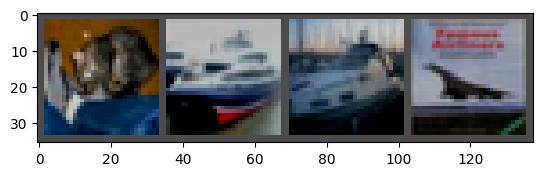

GroundTruth:  cat   ship  ship  plane
Predicted:  cat   ship  ship  plane
Best trial test set accuracy: 0.6125
Accuracy of plane is 69.5 %
Accuracy of car   is 71.6 %
Accuracy of bird  is 46.7 %
Accuracy of cat   is 47.0 %
Accuracy of deer  is 54.2 %
Accuracy of dog   is 43.3 %
Accuracy of frog  is 72.4 %
Accuracy of horse is 69.4 %
Accuracy of ship  is 76.1 %
Accuracy of truck is 62.3 %


In [ ]:
# Show the results of the best model

best_trial = result.get_best_trial("loss", "min", "last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")

best_trained_model = Net(best_trial.config["l1"], best_trial.config["l2"])
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if gpus_per_trial > 1:
        best_trained_model = nn.DataParallel(best_trained_model)
best_trained_model.to(device)

best_checkpoint = result.get_best_checkpoint(trial=best_trial, metric="accuracy", mode="max")
with best_checkpoint.as_directory() as checkpoint_dir:
    data_path = Path(checkpoint_dir) / "data.pkl"
    print("Checkpoint Path: ", data_path)
    with open(data_path, "rb") as fp:
        best_checkpoint_data = pickle.load(fp)

    best_trained_model.load_state_dict(best_checkpoint_data["net_state_dict"])
    test_acc, correct_pred, total_pred = test_accuracy(best_trained_model, device)
    print("Best trial test set accuracy: {}".format(test_acc))

    for classname, correct in correct_pred.items():
        accuracy = correct / total_pred[classname] * 100
        print(f'Accuracy of {classname:5s} is {accuracy:.1f} %')


In [ ]:
# Remove the artifacts
# /tmp/ray/*
# /root/ray_results/*
%rm -r /tmp/ray/*
%rm -r /root/ray_results/*

## Performance Profiling

- CPU and GPU time and memory
- Profiling of NN modules and training/inference runs
- Visualization with TensorBoard/HTA

### PyTorch Profiler

- PyTorch recipe: https://pytorch.org/tutorials/recipes/recipes/profiler_recipe.html

- Profiler supports multithreaded models
- Profiler runs in the same thread as the operation but it will also profile child operators that might run in another thread
- Concurrently-running profilers will be scoped to their own thread to prevent mixing of results

In [ ]:
%pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import torch
import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity

In [ ]:
model = models.resnet18()
inputs = torch.randn(5,3,224,224)

---
#### Profile CPU Execution Time
---

In [ ]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        model(inputs)

In [ ]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference         3.60%      17.601ms       100.00%     488.312ms     488.312ms             1  
                     aten::conv2d         0.62%       3.022ms        66.36%     324.028ms      16.201ms            20  
                aten::convolution         0.80%       3.921ms        65.74%     321.006ms      16.050ms            20  
               aten::_convolution         0.11%     545.000us        64.93%     317.085ms      15.854ms            20  
         aten::mkldnn_convolution        64.09%     312.941ms        64.82%     316.540ms      15.827ms            20  
                 aten::max_pool2d       

In [ ]:
print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=10)) # "Self" Excludes time in child operations

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
         aten::mkldnn_convolution        64.09%     312.941ms        64.82%     316.540ms      15.827ms            20  
    aten::max_pool2d_with_indices        11.39%      55.613ms        11.39%      55.613ms      55.613ms             1  
          aten::native_batch_norm        10.53%      51.398ms        10.58%      51.675ms       2.584ms            20  
                  model_inference         3.60%      17.601ms       100.00%     488.312ms     488.312ms             1  
                       aten::add_         1.72%       8.417ms         1.72%       8.417ms     300.607us            28  
                 aten::clamp_min_       

In [ ]:
print(prof.key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total", row_limit=10)) # Finer granularity

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls                                                                      Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                  model_inference         3.60%      17.601ms       100.00%     488.312ms     488.312ms             1                                                                                []  
                     aten::conv2d         0.60%       2.906ms        23.95%     116.946ms     116.946ms             1                             [[5, 3, 224, 224], [64, 3, 7, 7], [], [], [], 


---
#### Profile GPU Execution Time
---


In [ ]:
model = models.resnet18().cuda()
inputs = torch.randn(5,3,224,224).cuda()
with profile(activities=[
    ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("model_inference"):
        model(inputs)

In [ ]:
print(prof.key_averages().table(sort_by="self_cuda_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         0.00%       0.000us         0.00%       0.000us       0.000us     262.054ms        96.36%     262.054ms     131.027ms             2  
                                aten::cudnn_convolution        32.27%     137.159ms        60.72%     258.026ms      12.901ms       8.134ms         2.99%       8.134ms     406.700us            20  
cudnn_inf


---
#### Profile Memory
---

In [ ]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, record_shapes=True) as prof:
    with record_function("model_inference"):
        model(inputs)

In [ ]:
print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference        35.59%       6.955ms        99.87%      19.518ms      19.518ms       0.000us         0.00%       9.904ms       9.904ms           0 b           0 b           0 b    -109.39 M

In [ ]:
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::empty         5.92%       1.157ms         5.92%       1.157ms      11.570us       0.000us         0.00%       0.000us       0.000us           0 b           0 b      48.96 Mb      48.96 M


---
#### Tracing
---

In [ ]:
model = models.resnet18().cuda()
inputs = torch.randn(5, 3, 224, 224).cuda()

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
    model(inputs)

prof.export_chrome_trace("trace.json")

# Open trace file in Chrome window at chrome://tracing


---
#### Stack Traces
---

In [ ]:
with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    with_stack=True,
) as prof:
    with record_function("model_inference"):
        model(inputs)

In [ ]:
print(prof.key_averages(group_by_stack_n=5).table(sort_by="self_cuda_time_total", row_limit=2))
# Not working, may be a PyTorch issue

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         0.00%       0.000us         0.00%       0.000us       0.000us      10.519ms        51.51%      10.519ms      10.519ms             1  
                                aten::cudnn_convolution        29.68%       4.860ms        44.70%       7.319ms     365.950us       8.139ms        39.86%       8.139ms     406.950us            20  
---------

---
#### Long-running Jobs
---

- Jobs like training can take a long time and have different requirements
- Tracing all of a long job can be very slow and output large trace files

schedule - specifies a function that takes an integer argument (step number) as an input and returns an action for the profiler, the best way to use this parameter is to use torch.profiler.schedule helper function that can generate a schedule for you;

on_trace_ready - specifies a function that takes a reference to the profiler as an input and is called by the profiler each time the new trace is ready.

In [ ]:
from torch.profiler import schedule

my_schedule = schedule(
    skip_first=10, # ignore first 10 steps
    wait=5,        # Idle time before collection
    warmup=1,      # Initial discarded traces due to extra overhead
    active=3,      # Number of steps to record data
    repeat=2)      # Upper bound on the number of cycles (wait,warmup,active) to collect

In [ ]:
def trace_handler(p):
    output = p.key_averages().table(sort_by="self_cuda_time_total", row_limit=10)
    print(output)
    p.export_chrome_trace("/tmp/trace_" + str(p.step_num) + ".json")

with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    schedule=torch.profiler.schedule(
        wait=1,
        warmup=1,
        active=2),
    on_trace_ready=trace_handler
) as p:
    for idx in range(8):
        model(inputs)
        p.step()

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*         0.00%       0.000us         0.00%       0.000us       0.000us      20.225ms        45.53%      20.225ms      10.113ms             2  
                                aten::cudnn_convolution         7.24%       1.779ms        10.23%       2.514ms      62.850us      16.297ms        36.68%      16.297ms     407.425us            40  
cudnn_inf

### Profile Modules

- PyTorch tutorial: https://pytorch.org/tutorials/beginner/profiler.html

In [ ]:
import torch
import numpy as np
from torch import nn
import torch.autograd.profiler as profiler

In [ ]:
class MyModule(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(MyModule, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias)

    def forward(self, input, mask):
        with profiler.record_function("Linear"):
            out = self.linear(input)

        with profiler.record_function("Mask"):
            threshold = out.sum(axis=1).mean().item()
            hi_idx = np.argwhere(mask.cpu().numpy() > threshold) # Copy to CPU
            hi_idx = torch.from_numpy(hi_idx).cuda() # Copy to CUDA

        return out, hi_idx

In [ ]:
model = MyModule(500, 10).cuda()
input = torch.rand(128,500).cuda()
mask = torch.rand((500, 500, 500), dtype=torch.double).cuda()

# warm up cuda
model(input, mask)

with profiler.profile(with_stack=True, profile_memory=True) as prof:
    out, idx = model(input, mask)

In [ ]:
print(prof.key_averages(group_by_stack_n=5).table(sort_by='self_cpu_time_total', row_limit=5))

-------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                             Mask        63.83%        1.529s        99.94%        2.394s        2.394s           0 b    -953.67 Mb     817.74 Mb      -1.00 Kb             1  
                                  cudaMemcpyAsync        36.09%     864.348ms        36.09%     864.348ms     288.116ms           0 b           0 b           0 b           0 b             3  
                                      a

In [ ]:
# Improve the memory performace of Mask by casting as float instead of double
mask = torch.rand((500, 500, 500), dtype=torch.float).cuda()

# warm up cuda
model(input, mask)

with profiler.profile(with_stack=True, profile_memory=True) as prof:
    out, idx = model(input, mask)

In [ ]:
print(prof.key_averages(group_by_stack_n=5).table(sort_by='self_cpu_time_total', row_limit=5))

-------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                             Mask        72.76%        1.496s        99.91%        2.053s        2.053s           0 b    -476.84 Mb     817.78 Mb      -1.00 Kb             1  
                                  cudaMemcpyAsync        27.12%     557.360ms        27.12%     557.360ms     185.787ms           0 b           0 b           0 b           0 b             3  
                                      a

In [ ]:
# Improve the time performance by eliminating copies
class MyModule(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super(MyModule, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias)

    def forward(self, input, mask):
        with profiler.record_function("Linear"):
            out = self.linear(input)

        with profiler.record_function("Mask"):
            threshold = out.sum(axis=1).mean()
            hi_idx = (mask > threshold).nonzero(as_tuple=True)

        return out, hi_idx


model = MyModule(500, 10).cuda()
input = torch.rand(128, 500).cuda()
mask = torch.rand((500, 500, 500), dtype=torch.float).cuda()

# warm-up
model(input, mask)

with profiler.profile(with_stack=True, profile_memory=True) as prof:
    out, idx = model(input, mask)

print(prof.key_averages(group_by_stack_n=5).table(sort_by='self_cpu_time_total', row_limit=5))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        cudaMemcpyAsync        82.07%       7.260ms        82.07%       7.260ms       7.260ms           0 b           0 b           0 b           0 b             1  
                                            aten::addmm         9.47%     838.000us         9.73%     861.000us     861.000us           0 b           0 b       5.00 Kb       5.00 Kb             1  
         

### Tensorboard

- PyTorch tutorial: https://pytorch.org/tutorials/intermediate/tensorboard_profiler_tutorial.html

Also check Holistic Trace Analysis: https://hta.readthedocs.io/en/latest/index.html

- PyTorch tutorial: https://pytorch.org/tutorials/beginner/hta_intro_tutorial.html

In [ ]:
%pip install HolisticTraceAnalysis
%pip install torch_tb_profiler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: jupyter-

In [ ]:
import torch
import torch.nn
import torch.optim
import torch.profiler
import torch.utils.data
import torchvision.datasets
import torchvision.models
import torchvision.transforms as T

In [ ]:
transform = T.Compose(
    [T.Resize(224),
     T.ToTensor(),
     T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 44689421.04it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
# device = torch.device("cuda:0")
device = torch.device('cpu')
model = torchvision.models.resnet18(weights='IMAGENET1K_V1').to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model.train()
print("Resnet model")

Resnet model


In [ ]:
def train(data):
    inputs, labels = data[0].to(device=device), data[1].to(device=device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
with torch.profiler.profile(
    activities = [torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=1),
    on_trace_ready=torch.profiler.tensorboard_trace_handler(dir_name='./log/resnet18', use_gzip=False), # Generates and saves tensorboard files
    record_shapes=True,
    profile_memory=True,
    with_stack=True
) as prof:
    for step, batch_data in enumerate(train_loader):
        train(batch_data)
        prof.step()  # Need to call this at each step to notify profiler of steps' boundary.
        if step >= 1 + (1 + 3) * 2:
            break

/usr/local/lib/python3.10/dist-packages/torch/autograd/profiler.py:228: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


In [ ]:
# Tensorboard
# tensorboard --logdir=./log
# http://localhost:6006/#pytorch_profiler

In [ ]:
# HTA
from hta.trace_analysis import TraceAnalysis
trace_dir = "/content/log/resnet18/"
trace_files = {0 : '8c230de2449a_145.1717189838062872263.pt.trace.json'}
analyzer = TraceAnalysis(trace_dir=trace_dir, trace_files=trace_files)

2024-05-31 22:01:25,443 - hta - trace.py:L389 - INFO - /content/log/resnet18/
2024-05-31 22:01:25,446 - hta - trace.py:L535 - INFO - ranks=[0]
2024-05-31 22:01:26,987 - hta - trace.py:L118 - INFO - Parsed /content/log/resnet18/8c230de2449a_145.1717189838062872263.pt.trace.json time = 1.54 seconds 


In [ ]:
# Try HTA when GPU available
# temporal_breakdown_df = analyzer.get_temporal_breakdown()

## Benchmarking

- Time execution of functions over many runs
- Vary the inputs and number of threads used
- Compare different algorithms or environments


- PyTorch tutorial: https://pytorch.org/tutorials/recipes/recipes/benchmark.html

In [ ]:
import torch


def batched_dot_mul_sum(a, b):
    '''Computes batched dot by multiplying and summing'''
    return a.mul(b).sum(-1)


def batched_dot_bmm(a, b):
    '''Computes batched dot by reducing to ``bmm``'''
    a = a.reshape(-1, 1, a.shape[-1])
    b = b.reshape(-1, b.shape[-1], 1)
    return torch.bmm(a, b).flatten(-3)


# Input for benchmarking
x = torch.randn(10000, 64)

# Ensure that both functions compute the same output
assert batched_dot_mul_sum(x, x).allclose(batched_dot_bmm(x, x))

In [ ]:
# Python timeit module

import timeit

t0 = timeit.Timer(
    stmt='batched_dot_mul_sum(x, x)',
    setup='from __main__ import batched_dot_mul_sum',
    globals={'x': x})

t1 = timeit.Timer(
    stmt='batched_dot_bmm(x, x)',
    setup='from __main__ import batched_dot_bmm',
    globals={'x': x})

print(f'mul_sum(x, x):  {t0.timeit(100) / 100 * 1e6:>5.1f} us')
print(f'bmm(x, x):      {t1.timeit(100) / 100 * 1e6:>5.1f} us')

mul_sum(x, x):  1841.2 us
bmm(x, x):      4310.3 us


In [ ]:
'''
PyTorch benchmark

- Performs synchronization with CUDA
- Accounts for warm-up time
- Runs a single thread by default
- Reports the time per run instead of the total runtime
'''
import torch.utils.benchmark as benchmark

t0 = benchmark.Timer(
    stmt='batched_dot_mul_sum(x, x)',
    setup='from __main__ import batched_dot_mul_sum',
    globals={'x': x})

t1 = benchmark.Timer(
    stmt='batched_dot_bmm(x, x)',
    setup='from __main__ import batched_dot_bmm',
    globals={'x': x})

print(t0.timeit(100))
print(t1.timeit(100))

batched_dot_mul_sum(x, x)
setup: from __main__ import batched_dot_mul_sum
  653.17 us
  1 measurement, 100 runs , 1 thread
batched_dot_bmm(x, x)
setup: from __main__ import batched_dot_bmm
  1.78 ms
  1 measurement, 100 runs , 1 thread


In [ ]:
# x = torch.randn(10000, 1024, device='cuda')

num_threads = torch.get_num_threads()
print(f'Benchmarking on {num_threads} threads')

t0 = benchmark.Timer(
    stmt='batched_dot_mul_sum(x, x)',
    setup='from __main__ import batched_dot_mul_sum',
    globals={'x': x},
    num_threads=num_threads,
    label='Multithreaded batch dot',
    sub_label='Implemented using mul and sum')

t1 = benchmark.Timer(
    stmt='batched_dot_bmm(x, x)',
    setup='from __main__ import batched_dot_bmm',
    globals={'x': x},
    num_threads=num_threads,
    label='Multithreaded batch dot',
    sub_label='Implemented using bmm')

print(t0.timeit(100))
print(t1.timeit(100))

Benchmarking on 1 threads
Multithreaded batch dot: Implemented using mul and sum
setup: from __main__ import batched_dot_mul_sum
  524.99 us
  1 measurement, 100 runs , 1 thread
Multithreaded batch dot: Implemented using bmm
setup: from __main__ import batched_dot_bmm
  1.11 ms
  1 measurement, 100 runs , 1 thread


In [ ]:
# Autorange - Compute statistics for a period of time (min 200 ms)

m0 = t0.blocked_autorange()
m1 = t1.blocked_autorange()

print(m0)
print(m1)

print(f"Mean:   {m0.mean * 1e6:6.2f} us")
print(f"Median: {m0.median * 1e6:6.2f} us")

Multithreaded batch dot: Implemented using mul and sum
setup: from __main__ import batched_dot_mul_sum
  Median: 594.25 us
  IQR:    261.55 us (550.56 to 812.11)
  115 measurements, 1 runs per measurement, 1 thread
           This suggests significant environmental influence.
Multithreaded batch dot: Implemented using bmm
setup: from __main__ import batched_dot_bmm
  Median: 1.77 ms
  IQR:    3.20 ms (1.71 to 4.91)
  50 measurements, 1 runs per measurement, 1 thread
           This suggests significant environmental influence.
Mean:   1743.68 us
Median: 594.25 us


In [ ]:
# Compare benchmark results - vary inputs, # of threads
from itertools import product

# Compare takes a list of measurements which we'll save in results.
results = []

sizes = [1, 64, 1024]
for b, n in product(sizes, sizes):
    # label and sub_label are the rows
    # description is the column
    label = 'Batched dot'
    sub_label = f'[{b}, {n}]'
    x = torch.ones((b, n))
    for num_threads in [1, 4, 16]:
        results.append(benchmark.Timer(
            stmt='batched_dot_mul_sum(x, x)',
            setup='from __main__ import batched_dot_mul_sum',
            globals={'x': x},
            num_threads=num_threads,
            label=label,
            sub_label=sub_label,
            description='mul/sum',
        ).blocked_autorange(min_run_time=1))
        results.append(benchmark.Timer(
            stmt='batched_dot_bmm(x, x)',
            setup='from __main__ import batched_dot_bmm',
            globals={'x': x},
            num_threads=num_threads,
            label=label,
            sub_label=sub_label,
            description='bmm',
        ).blocked_autorange(min_run_time=1))

compare = benchmark.Compare(results)
compare.trim_significant_figures()
compare.colorize()
compare.print()

[------------ Batched dot ------------]
                    |  mul/sum  |  bmm 
1 threads: ----------------------------
      [1, 1]        |      10   |    10
      [1, 64]       |      11   |    20
      [1, 1024]     |       7   |    11
      [64, 1]       |      12   |    10
      [64, 64]      |       9   |    17
      [64, 1024]    |      32   |   230
      [1024, 1]     |       9   |    18
      [1024, 64]    |      52   |   115
      [1024, 1024]  |     590   |  3510
4 threads: ----------------------------
      [1, 1]        |       7   |    10
      [1, 64]       |       7   |    10
      [1, 1024]     |       7   |    11
      [64, 1]       |       8   |    11
      [64, 64]      |       9   |    17
      [64, 1024]    |      90   |   170
      [1024, 1]     |       9   |    18
      [1024, 64]    |     100   |   110
      [1024, 1024]  |     630   |  2000
16 threads: ---------------------------
      [1, 1]        |       7   |    16
      [1, 64]       |       7   |    11


In [ ]:
# Saving and loading with pickle
# Can do A/B test with results from different Python envs
import pickle

ab_test_results = []
for env in ('environment A: mul/sum', 'environment B: bmm'):
    for b, n in ((1, 1), (1024, 10000), (10000, 1)):
        x = torch.ones((b, n))
        dot_fn = (batched_dot_mul_sum if env == 'environment A: mul/sum' else batched_dot_bmm)
        m = benchmark.Timer(
            stmt='batched_dot(x, x)',
            globals={'x': x, 'batched_dot': dot_fn},
            num_threads=1,
            label='Batched dot',
            description=f'[{b}, {n}]',
            env=env,
        ).blocked_autorange(min_run_time=1)
        ab_test_results.append(pickle.dumps(m))

ab_results = [pickle.loads(i) for i in ab_test_results]
compare = benchmark.Compare(ab_results)
compare.trim_significant_figures()
compare.colorize()
compare.print()

# Demonstrate pickle round-trip
round_tripped_results = pickle.loads(pickle.dumps(results))
assert(str(benchmark.Compare(results)) == str(benchmark.Compare(round_tripped_results)))

[------------------------------------- Batched dot -------------------------------------]
                                               |  [1, 1]  |  [1024, 10000]  |  [10000, 1]
1 threads: ------------------------------------------------------------------------------
  (environment A: mul/sum)  batched_dot(x, x)  |    10    |      31000      |      18    
  (environment B: bmm)      batched_dot(x, x)  |    10    |      30000      |     170    

Times are in microseconds (us).



In [ ]:
# Inputs with fuzzed parameters - gives more variety for input tensors
from torch.utils.benchmark import Fuzzer, FuzzedParameter, FuzzedTensor, ParameterAlias

# Generates random tensors with 128 to 10000000 elements and sizes k0 and k1 chosen from a
# ``loguniform`` distribution in [1, 10000], 40% of which will be discontiguous on average.
example_fuzzer = Fuzzer(
    parameters = [
        FuzzedParameter('k0', minval=1, maxval=10000, distribution='loguniform'),
        FuzzedParameter('k1', minval=1, maxval=10000, distribution='loguniform'),
    ],
    tensors = [
        FuzzedTensor('x', size=('k0', 'k1'), min_elements=128, max_elements=10000000, probability_contiguous=0.6)
    ],
    seed=0,
)

results = []
for tensors, tensor_params, params in example_fuzzer.take(10):
    # description is the column label
    sub_label=f"{params['k0']:<6} x {params['k1']:<4} {'' if tensor_params['x']['is_contiguous'] else '(discontiguous)'}"
    results.append(benchmark.Timer(
        stmt='batched_dot_mul_sum(x, x)',
        setup='from __main__ import batched_dot_mul_sum',
        globals=tensors,
        label='Batched dot',
        sub_label=sub_label,
        description='mul/sum',
    ).blocked_autorange(min_run_time=1))
    results.append(benchmark.Timer(
        stmt='batched_dot_bmm(x, x)',
        setup='from __main__ import batched_dot_bmm',
        globals=tensors,
        label='Batched dot',
        sub_label=sub_label,
        description='bmm',
    ).blocked_autorange(min_run_time=1))

compare = benchmark.Compare(results)
compare.trim_significant_figures()
compare.print()

[--------------------- Batched dot ---------------------]
                                     |  mul/sum  |   bmm 
1 threads: ----------------------------------------------
      725    x 257                   |     150   |    500
      49     x 383                   |      17   |     66
      34     x 1468                  |      18   |    175
      187    x 5039                  |     529   |   3110
      2140   x 1296 (discontiguous)  |    2400   |  64000
      78     x 1598                  |      43   |    421
      519    x 763                   |     200   |   1300
      141    x 1082                  |      71   |    610
      78     x 5    (discontiguous)  |       8   |     15
      187    x 1                     |       8   |     12

Times are in microseconds (us).



In [ ]:
# Instruction counts with Callgrind
# More deterministic proxy for where time is spent in a process
# Use C++ code to show the difference of passing by value or reference
# Note: I did not run this code. Need more packages

batched_dot_src = """\
/* ---- Python ---- */
// def batched_dot_mul_sum(a, b):
//     return a.mul(b).sum(-1)

torch::Tensor batched_dot_mul_sum_v0(
    const torch::Tensor a,
    const torch::Tensor b) {
  return a.mul(b).sum(-1);
}

torch::Tensor batched_dot_mul_sum_v1(
    const torch::Tensor& a,
    const torch::Tensor& b) {
  return a.mul(b).sum(-1);
}
"""


# PyTorch makes it easy to test our C++ implementations by providing a utility
# to JIT compile C++ source into Python extensions:
import os
from torch.utils import cpp_extension
cpp_lib = cpp_extension.load_inline(
    name='cpp_lib',
    cpp_sources=batched_dot_src,
    extra_cflags=['-O3'],
    extra_include_paths=[
        # `load_inline` needs to know where to find ``pybind11`` headers.
        os.path.join(os.getenv('CONDA_PREFIX'), 'include')
    ],
    functions=['batched_dot_mul_sum_v0', 'batched_dot_mul_sum_v1']
)

# `load_inline` will create a shared object that is loaded into Python. When we collect
# instruction counts Timer will create a subprocess, so we need to re-import it. The
# import process is slightly more complicated for C extensions, but that's all we're
# doing here.
module_import_str = f"""\
# https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path
import importlib.util
spec = importlib.util.spec_from_file_location("cpp_lib", {repr(cpp_lib.__file__)})
cpp_lib = importlib.util.module_from_spec(spec)
spec.loader.exec_module(cpp_lib)"""

import textwrap
def pretty_print(result):
    """Import machinery for ``cpp_lib.so`` can get repetitive to look at."""
    print(repr(result).replace(textwrap.indent(module_import_str, "  "), "  import cpp_lib"))


t_baseline = benchmark.Timer(
    stmt='batched_dot_mul_sum(x, x)',
    setup='''\
from __main__ import batched_dot_mul_sum
x = torch.randn(2, 2)''')

t0 = benchmark.Timer(
    stmt='cpp_lib.batched_dot_mul_sum_v0(x, x)',
    setup=f'''\
{module_import_str}
x = torch.randn(2, 2)''')

t1 = benchmark.Timer(
    stmt='cpp_lib.batched_dot_mul_sum_v1(x, x)',
    setup=f'''\
{module_import_str}
x = torch.randn(2, 2)''')

# Moving to C++ did indeed reduce overhead, but it's hard to tell which
# calling convention is more efficient. v1 (call with references) seems to
# be a bit faster, but it's within measurement error.
pretty_print(t_baseline.blocked_autorange())
pretty_print(t0.blocked_autorange())
pretty_print(t1.blocked_autorange())

In [ ]:
# Let's use ``Callgrind`` to determine which is better.
stats_v0 = t0.collect_callgrind()
stats_v1 = t1.collect_callgrind()

pretty_print(stats_v0)
pretty_print(stats_v1)

# `.as_standardized` removes file names and some path prefixes, and makes
# it easier to read the function symbols.
stats_v0 = stats_v0.as_standardized()
stats_v1 = stats_v1.as_standardized()

# `.delta` diffs the instruction counts, and `.denoise` removes several
# functions in the Python interpreter that are known to have significant
# jitter.
delta = stats_v1.delta(stats_v0).denoise()

# `.transform` is a convenience API for transforming function names. It is
# useful for increasing cancelation when ``diff-ing`` instructions, as well as
# just generally improving readability.
replacements = (
    ("???:void pybind11", "pybind11"),
    ("batched_dot_mul_sum_v0", "batched_dot_mul_sum_v1"),
    ("at::Tensor, at::Tensor", "..."),
    ("at::Tensor const&, at::Tensor const&", "..."),
    ("auto torch::detail::wrap_pybind_function_impl_", "wrap_pybind_function_impl_"),
)
for before, after in replacements:
    delta = delta.transform(lambda l: l.replace(before, after))

# We can use print options to control how much of the function to display.
torch.set_printoptions(linewidth=160)

# Once parsed, the instruction counts make clear that passing `a` and `b`
# by reference is more efficient as it skips some ``c10::TensorImpl`` bookkeeping
# for the intermediate Tensors, and is also works better with ``pybind11``. This
# is consistent with our noisy wall time observations.
print(delta)

## Parameterizations

- Regularization techniques that use a function to add extra structure to parameters to enhance learning and reduce overfitting
- Examples include making matricies orthogonal or dividing by a norm


- PyTorch tutorial: https://pytorch.org/tutorials/intermediate/parametrizations.html

### Parameterization by hand - Symmetric weights

In [ ]:
import torch
import torch.nn as nn
import torch.nn.utils.parametrize as parametrize

def symmetric(X):
    return X.triu() + X.triu(1).transpose(-1, -2)

X = torch.rand(3, 3)
A = symmetric(X)
assert torch.allclose(A, A.T)  # A is symmetric
print(A)                       # Quick visual check

tensor([[0.5632, 0.2787, 0.9728],
        [0.2787, 0.7709, 0.4434],
        [0.9728, 0.4434, 0.2891]])


In [ ]:
class LinearSymmetric(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(n_features, n_features))

    def forward(self, x):
        A = symmetric(self.weight)
        return x @ A


layer = LinearSymmetric(3)
out = layer(torch.rand(8, 3))

Issues:
- The layer needs to implemented explicitly
- Parameterization is specific to the layer
- Recomputes A each pass

### PyTorch Parameterizations


In [ ]:
class Symmetric(nn.Module):
    def forward(self, X):
        return X.triu() + X.triu(1).transpose(-1, -2)

layer = nn.Linear(3, 3)
parametrize.register_parametrization(layer, "weight", Symmetric())

A = layer.weight
assert torch.allclose(A, A.T)  # A is symmetric
print(A)                       # Quick visual check

tensor([[ 0.2021, -0.0673,  0.5310],
        [-0.0673, -0.3446, -0.5545],
        [ 0.5310, -0.5545,  0.2324]], grad_fn=<AddBackward0>)


In [ ]:
class Skew(nn.Module):
    def forward(self, X):
        A = X.triu(1)
        return A - A.transpose(-1, -2)


cnn = nn.Conv2d(in_channels=5, out_channels=8, kernel_size=3)
parametrize.register_parametrization(cnn, "weight", Skew())
# Print a few kernels
print(cnn.weight[0, 1])
print(cnn.weight[2, 2])

tensor([[ 0.0000, -0.0331, -0.0967],
        [ 0.0331,  0.0000,  0.0542],
        [ 0.0967, -0.0542,  0.0000]], grad_fn=<SelectBackward0>)
tensor([[ 0.0000,  0.1168,  0.0632],
        [-0.1168,  0.0000,  0.0190],
        [-0.0632, -0.0190,  0.0000]], grad_fn=<SelectBackward0>)


In [ ]:
# Caching parametrization
class NoisyParametrization(nn.Module):
    def forward(self, X):
        print("Computing the Parametrization")
        return X

layer = nn.Linear(4, 4)
parametrize.register_parametrization(layer, "weight", NoisyParametrization())
print("Here, layer.weight is recomputed every time we call it")
foo = layer.weight + layer.weight.T
bar = layer.weight.sum()
with parametrize.cached():
    print("Here, it is computed just the first time layer.weight is called")
    foo = layer.weight + layer.weight.T
    bar = layer.weight.sum()

Computing the Parametrization
Here, layer.weight is recomputed every time we call it
Computing the Parametrization
Computing the Parametrization
Computing the Parametrization
Here, it is computed just the first time layer.weight is called
Computing the Parametrization


In [ ]:
# Concatenating Parametrizations
class CayleyMap(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.register_buffer("Id", torch.eye(n))

    def forward(self, X):
        # (I + X)(I - X)^{-1}
        return torch.linalg.solve(self.Id - X, self.Id + X)

layer = nn.Linear(3, 3)
parametrize.register_parametrization(layer, "weight", Skew())
parametrize.register_parametrization(layer, "weight", CayleyMap(3))
X = layer.weight
print(torch.dist(X.T @ X, torch.eye(3)))  # X is orthogonal

tensor(1.7096e-07, grad_fn=<DistBackward0>)


In [ ]:
# Initialize Parametrizations - right_inverse
class Skew(nn.Module):
    def forward(self, X):
        A = X.triu(1)
        return A - A.transpose(-1, -2)

    def right_inverse(self, A):
        # We assume that A is skew-symmetric
        # We take the upper-triangular elements, as these are those used in the forward
        return A.triu(1)

layer = nn.Linear(3, 3)
parametrize.register_parametrization(layer, "weight", Skew())
X = torch.rand(3, 3)
X = X - X.T                             # X is now skew-symmetric
layer.weight = X                        # Initialize layer.weight to be X
print(torch.dist(layer.weight, X))      # layer.weight == X

tensor(0., grad_fn=<DistBackward0>)


In [ ]:
# Removing Parametrizations
layer = nn.Linear(3, 3)
print("Before:")
print(layer)
print(layer.weight)
parametrize.register_parametrization(layer, "weight", Skew())
print("\nParametrized:")
print(layer)
print(layer.weight)
parametrize.remove_parametrizations(layer, "weight")
print("\nAfter. Weight has skew-symmetric values but it is unconstrained:")
print(layer)
print(layer.weight)

Before:
Linear(in_features=3, out_features=3, bias=True)
Parameter containing:
tensor([[ 0.0450,  0.3274,  0.4546],
        [ 0.1088, -0.1364,  0.3072],
        [ 0.4572,  0.4564,  0.3010]], requires_grad=True)

Parametrized:
ParametrizedLinear(
  in_features=3, out_features=3, bias=True
  (parametrizations): ModuleDict(
    (weight): ParametrizationList(
      (0): Skew()
    )
  )
)
tensor([[ 0.0000,  0.3274,  0.4546],
        [-0.3274,  0.0000,  0.3072],
        [-0.4546, -0.3072,  0.0000]], grad_fn=<SubBackward0>)

After. Weight has skew-symmetric values but it is unconstrained:
Linear(in_features=3, out_features=3, bias=True)
Parameter containing:
tensor([[ 0.0000,  0.3274,  0.4546],
        [-0.3274,  0.0000,  0.3072],
        [-0.4546, -0.3072,  0.0000]], requires_grad=True)


In [ ]:
# Rollback to original version (non-parametrized)
layer = nn.Linear(3, 3)
print("Before:")
print(layer)
print(layer.weight)
parametrize.register_parametrization(layer, "weight", Skew())
print("\nParametrized:")
print(layer)
print(layer.weight)
parametrize.remove_parametrizations(layer, "weight", leave_parametrized=False)
print("\nAfter. Same as Before:")
print(layer)
print(layer.weight)

Before:
Linear(in_features=3, out_features=3, bias=True)
Parameter containing:
tensor([[ 0.3402,  0.1632, -0.1857],
        [ 0.5443,  0.0114,  0.3441],
        [-0.0584,  0.0381, -0.0388]], requires_grad=True)

Parametrized:
ParametrizedLinear(
  in_features=3, out_features=3, bias=True
  (parametrizations): ModuleDict(
    (weight): ParametrizationList(
      (0): Skew()
    )
  )
)
tensor([[ 0.0000,  0.1632, -0.1857],
        [-0.1632,  0.0000,  0.3441],
        [ 0.1857, -0.3441,  0.0000]], grad_fn=<SubBackward0>)

After. Same as Before:
Linear(in_features=3, out_features=3, bias=True)
Parameter containing:
tensor([[ 0.0000,  0.1632, -0.1857],
        [ 0.0000,  0.0000,  0.3441],
        [ 0.0000,  0.0000,  0.0000]], requires_grad=True)


## Pruning

- Efficiently compress models by reducing the number of parameters
- Assumes base neural networks are over-parametrized


- PyTorch tutorial: https://pytorch.org/tutorials/intermediate/pruning_tutorial.html

In [ ]:
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet().to(device=device)

In [ ]:
# Inspect the unpruned module
module = model.conv1
print(list(module.named_parameters()))
print(list(module.named_buffers()))

[('weight', Parameter containing:
tensor([[[[-7.1899e-02,  6.8961e-02,  1.8437e-01,  1.8879e-01, -9.7997e-02],
          [ 1.2511e-01, -6.2407e-02,  1.3871e-01, -8.1274e-02,  1.1043e-02],
          [-1.8767e-01, -3.7982e-02,  8.5971e-02, -2.9066e-02,  1.0911e-01],
          [ 6.7399e-02, -6.9951e-02,  1.4982e-01,  1.5166e-01, -1.9563e-01],
          [-6.7001e-02, -7.9019e-02, -9.1224e-02, -1.9324e-01,  3.8285e-02]]],


        [[[ 1.1506e-01,  5.4059e-04, -1.7525e-01, -2.9687e-02, -1.0025e-01],
          [-1.4979e-01,  1.9993e-01, -1.7546e-01,  1.4791e-01,  1.4370e-02],
          [ 1.3886e-01, -1.4606e-01, -4.8855e-02, -9.5823e-02, -1.2789e-01],
          [-4.6367e-02, -1.4612e-01, -6.9884e-02,  7.4581e-02, -1.9142e-01],
          [ 1.8051e-01, -1.6570e-02, -9.7502e-03,  1.0295e-01,  1.6524e-01]]],


        [[[ 1.3684e-01,  6.5224e-02, -1.9694e-01,  3.7557e-02,  2.5860e-02],
          [-1.8559e-01,  6.9837e-02,  1.2736e-01,  1.8080e-01, -8.8097e-02],
          [ 1.2533e-01, -1.5148e-0

In [ ]:
# Random pruning
prune.random_unstructured(module, name='weight', amount=0.3)

# Can also prune bias
# prune.l1_unstructured(module, name="bias", amount=3)

print(list(module.named_parameters()))
print(list(module.named_buffers()))
print(module.weight)
print(module._forward_pre_hooks)

[('bias', Parameter containing:
tensor([ 0.1289, -0.0618,  0.0900, -0.1107, -0.0214, -0.0261],
       requires_grad=True)), ('weight_orig', Parameter containing:
tensor([[[[-7.1899e-02,  6.8961e-02,  1.8437e-01,  1.8879e-01, -9.7997e-02],
          [ 1.2511e-01, -6.2407e-02,  1.3871e-01, -8.1274e-02,  1.1043e-02],
          [-1.8767e-01, -3.7982e-02,  8.5971e-02, -2.9066e-02,  1.0911e-01],
          [ 6.7399e-02, -6.9951e-02,  1.4982e-01,  1.5166e-01, -1.9563e-01],
          [-6.7001e-02, -7.9019e-02, -9.1224e-02, -1.9324e-01,  3.8285e-02]]],


        [[[ 1.1506e-01,  5.4059e-04, -1.7525e-01, -2.9687e-02, -1.0025e-01],
          [-1.4979e-01,  1.9993e-01, -1.7546e-01,  1.4791e-01,  1.4370e-02],
          [ 1.3886e-01, -1.4606e-01, -4.8855e-02, -9.5823e-02, -1.2789e-01],
          [-4.6367e-02, -1.4612e-01, -6.9884e-02,  7.4581e-02, -1.9142e-01],
          [ 1.8051e-01, -1.6570e-02, -9.7502e-03,  1.0295e-01,  1.6524e-01]]],


        [[[ 1.3684e-01,  6.5224e-02, -1.9694e-01,  3.7557e-0

In [ ]:
# Stacked Pruning - Prune the #of channels
prune.ln_structured(module, name="weight", amount=0.5, n=2, dim=0)

# As we can verify, this will zero out all the connections corresponding to
# 50% (3 out of 6) of the channels, while preserving the action of the
# previous mask.
print(module.weight)

tensor([[[[-0.0000,  0.0000,  0.0000,  0.1888, -0.0980],
          [ 0.0000, -0.0000,  0.0000, -0.0000,  0.0000],
          [-0.0000, -0.0000,  0.0000, -0.0000,  0.0000],
          [ 0.0674, -0.0000,  0.0000,  0.1517, -0.0000],
          [-0.0000, -0.0000, -0.0000, -0.0000,  0.0000]]],


        [[[ 0.0000,  0.0005, -0.0000, -0.0297, -0.0000],
          [-0.0000,  0.1999, -0.0000,  0.0000,  0.0000],
          [ 0.0000, -0.1461, -0.0000, -0.0000, -0.0000],
          [-0.0000, -0.0000, -0.0000,  0.0000, -0.0000],
          [ 0.0000, -0.0000, -0.0000,  0.0000,  0.0000]]],


        [[[ 0.0000,  0.0000, -0.0000,  0.0376,  0.0259],
          [-0.1856,  0.0000,  0.0000,  0.0000, -0.0000],
          [ 0.0000, -0.1515, -0.0000, -0.0000,  0.0349],
          [ 0.1977,  0.0000,  0.0000,  0.0000, -0.0000],
          [-0.0000,  0.0000,  0.0831, -0.0000,  0.0000]]],


        [[[ 0.0000, -0.0000,  0.0000,  0.0000, -0.0000],
          [ 0.0000,  0.0000,  0.0000, -0.0000, -0.0000],
          [ 0.0000,

In [ ]:
# Serializing pruned model
print(model.state_dict().keys())

odict_keys(['conv1.bias', 'conv1.weight_orig', 'conv1.weight_mask', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])


In [ ]:
# Make pruned state permanent
prune.remove(module, 'weight')
print(list(module.named_parameters()))

[('bias', Parameter containing:
tensor([ 0.1289, -0.0618,  0.0900, -0.1107, -0.0214, -0.0261],
       requires_grad=True)), ('weight', Parameter containing:
tensor([[[[-0.0000,  0.0000,  0.0000,  0.1888, -0.0980],
          [ 0.0000, -0.0000,  0.0000, -0.0000,  0.0000],
          [-0.0000, -0.0000,  0.0000, -0.0000,  0.0000],
          [ 0.0674, -0.0000,  0.0000,  0.1517, -0.0000],
          [-0.0000, -0.0000, -0.0000, -0.0000,  0.0000]]],


        [[[ 0.0000,  0.0005, -0.0000, -0.0297, -0.0000],
          [-0.0000,  0.1999, -0.0000,  0.0000,  0.0000],
          [ 0.0000, -0.1461, -0.0000, -0.0000, -0.0000],
          [-0.0000, -0.0000, -0.0000,  0.0000, -0.0000],
          [ 0.0000, -0.0000, -0.0000,  0.0000,  0.0000]]],


        [[[ 0.0000,  0.0000, -0.0000,  0.0376,  0.0259],
          [-0.1856,  0.0000,  0.0000,  0.0000, -0.0000],
          [ 0.0000, -0.1515, -0.0000, -0.0000,  0.0349],
          [ 0.1977,  0.0000,  0.0000,  0.0000, -0.0000],
          [-0.0000,  0.0000,  0.0831,

In [ ]:
# Pruning multiple parameters
new_model = LeNet()
for name, module in new_model.named_modules():
    # prune 20% of connections in all 2D-conv layers
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module, name='weight', amount=0.2)
    # prune 40% of connections in all linear layers
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name='weight', amount=0.4)

print(dict(new_model.named_buffers()).keys())  # to verify that all masks exist

dict_keys(['conv1.weight_mask', 'conv2.weight_mask', 'fc1.weight_mask', 'fc2.weight_mask', 'fc3.weight_mask'])


In [ ]:
# Global pruning
model = LeNet()

parameters_to_prune = (
    (model.conv1, 'weight'),
    (model.conv2, 'weight'),
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
    (model.fc3, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
)

print(
    "Sparsity in conv1.weight: {:.2f}%".format(
        100. * float(torch.sum(model.conv1.weight == 0))
        / float(model.conv1.weight.nelement())
    )
)
print(
    "Sparsity in conv2.weight: {:.2f}%".format(
        100. * float(torch.sum(model.conv2.weight == 0))
        / float(model.conv2.weight.nelement())
    )
)
print(
    "Sparsity in fc1.weight: {:.2f}%".format(
        100. * float(torch.sum(model.fc1.weight == 0))
        / float(model.fc1.weight.nelement())
    )
)
print(
    "Sparsity in fc2.weight: {:.2f}%".format(
        100. * float(torch.sum(model.fc2.weight == 0))
        / float(model.fc2.weight.nelement())
    )
)
print(
    "Sparsity in fc3.weight: {:.2f}%".format(
        100. * float(torch.sum(model.fc3.weight == 0))
        / float(model.fc3.weight.nelement())
    )
)
print(
    "Global sparsity: {:.2f}%".format(
        100. * float(
            torch.sum(model.conv1.weight == 0)
            + torch.sum(model.conv2.weight == 0)
            + torch.sum(model.fc1.weight == 0)
            + torch.sum(model.fc2.weight == 0)
            + torch.sum(model.fc3.weight == 0)
        )
        / float(
            model.conv1.weight.nelement()
            + model.conv2.weight.nelement()
            + model.fc1.weight.nelement()
            + model.fc2.weight.nelement()
            + model.fc3.weight.nelement()
        )
    )
)

Sparsity in conv1.weight: 6.00%
Sparsity in conv2.weight: 14.25%
Sparsity in fc1.weight: 22.18%
Sparsity in fc2.weight: 11.97%
Sparsity in fc3.weight: 10.95%
Global sparsity: 20.00%


In [ ]:
# Custom pruning
class FooBarPruningMethod(prune.BasePruningMethod):
    """Prune every other entry in a tensor
    """
    PRUNING_TYPE = 'unstructured'

    def compute_mask(self, t, default_mask):
        mask = default_mask.clone()
        mask.view(-1)[::2] = 0
        return mask

def foobar_unstructured(module, name):
    """Prunes tensor corresponding to parameter called `name` in `module`
    by removing every other entry in the tensors.
    Modifies module in place (and also return the modified module)
    by:
    1) adding a named buffer called `name+'_mask'` corresponding to the
    binary mask applied to the parameter `name` by the pruning method.
    The parameter `name` is replaced by its pruned version, while the
    original (unpruned) parameter is stored in a new parameter named
    `name+'_orig'`.

    Args:
        module (nn.Module): module containing the tensor to prune
        name (string): parameter name within `module` on which pruning
                will act.

    Returns:
        module (nn.Module): modified (i.e. pruned) version of the input
            module

    Examples:
        >>> m = nn.Linear(3, 4)
        >>> foobar_unstructured(m, name='bias')
    """
    FooBarPruningMethod.apply(module, name)
    return module

model = LeNet()
foobar_unstructured(model.fc3, name='bias')

print(model.fc3.bias_mask)

tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1.])
